# Workspace

## Mount Google Drive

In [1]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configure Workspace
 - Fix SEED
 - Initialize Logger

In [0]:
!mkdir resources runs
!rm -rf sample_data

In [0]:
import os
import random
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

import nltk
from nltk import bigrams
from nltk.util import ngrams




def configure_workspace(SEED=1873337):
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

    logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s",
                        datefmt='%H:%M:%S', level=logging.INFO)

# Data

## Utils save & load pickle files

In [0]:
import pickle


def save_pickle(save_to, save_what):
    with open(save_to, mode='wb') as f:
        pickle.dump(save_what, f)


def load_pickle(load_from):
    with open(load_from, 'rb') as f:
        return pickle.load(f)

## Parse and process the data, to create vocabulary from unigrams and bigrams

In [0]:
class WikiDataset(Dataset):
    def __init__(self, input_file_path: str, gold_file_path: str, max_char_len=256):
        configure_workspace()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_len = max_char_len
        self.parse_dataset(input_file_path, gold_file_path)
        self.get_unigrams()
        self.create_vocabulary()
        self.encode_labels()
        self.encoded_data = None
        self.vocab_size = len(self.char2idx.keys())
        self.out_vocab_size = len(self.label2idx.keys())

        print(f'Input Vocabulary Size: {self.vocab_size}')
        print(f'Output Vocabulary Size: {self.out_vocab_size}')

    def parse_dataset(self, input_file_path, gold_file_path):
        lines = []
        with open(input_file_path, encoding='utf-8', mode='r') as file_:
            lines = file_.readlines()
        self.data_x = [line.strip() for line in lines]

        lines_ = []
        with open(gold_file_path, encoding='utf-8', mode='r') as gold_file_:
            lines_ = gold_file_.readlines()

        self.data_y = [line.strip() for line in lines_]

    def encode_labels(self):
        self.label2idx = {'<PAD>':0, 'B': 1, 'I': 2, 'S': 3}
        self.idx2label = {0: '<PAD>', 1: 'B', 2: 'I', 3: 'S'}

    def get_unigrams(self):
        chars = []
        for sentence in self.data_x:
            chars.extend([word for word in sentence])
        self.unigrams = sorted(list(set(chars)))

    def create_vocabulary(self):
        self.char2idx = dict()
        self.char2idx['<PAD>'] = 0
        self.char2idx['<UNK>'] = 1
        self.char2idx.update(
            {val: key for (key, val) in enumerate(self.unigrams, start=2)})
        self.idx2char = {val: key for (key, val) in self.char2idx.items()}

    def char_padding(self, sentence_):
        if len(sentence_) > self.max_len:
            sentence_ = sentence_[:self.max_len]
        else:
            for _ in range(self.max_len - len(sentence_)):
                sentence_.append(self.label2idx.get('<PAD>'))
        return sentence_

    def vectorize_data(self):
        """
        Converts data_x from a seq of tokens (str) to a seq of indices (int)
        """
        train_x = []
        for sentence in self.data_x:
            sentence_ = [self.char2idx.get(char, 1) for char in sentence]
            train_x.append(self.char_padding(sentence_))
        self.train_x = train_x

        train_y = []
        for sentence in self.data_y:
            sentence_ = [self.label2idx.get(label) for label in sentence]
            train_y.append(self.char_padding(sentence_))
        self.train_y = train_y
        self.encode_data()
    
    def encode_data(self):
        self.encoded_data = list()
        # data_x.shape = [samples_num, max_chars_sentence]
        # assert self.train_x.shape == self.train_y.shape
        for i in range(len(self.train_x)):
            train_x = torch.LongTensor(self.train_x[i]).to(self.device)
            train_y = torch.LongTensor(self.train_y[i]).to(self.device)
            self.encoded_data.append({"inputs": train_x, "outputs": train_y})

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("Trying to retrieve elements, but dataset is not vectorized yet")
        return self.encoded_data[idx]

    @staticmethod
    def decode_output(logits: torch.Tensor, idx2label):
        max_indices = torch.argmax(logits, -1).tolist()  # shape = (batch_size, max_len)
        predictions = list()
        for indices in max_indices:
            predictions.append([idx2label[i] for i in indices])
        return predictions

    @staticmethod
    def decode_data(data: torch.Tensor, idx2label):
        data_ = data.tolist()
        return [idx2label.get(idx, None) for idx in data_]

In [0]:
DATA_PATH = '/content/drive/My Drive/Bonus_NLP/data'
RESOURCES_PATH = os.path.join(os.getcwd(), 'resources')
LOGS_PATH = os.path.join(os.getcwd(), 'logs')

file_path = os.path.join(DATA_PATH, 'en.wiki.sentences.train')
gold_file_path = os.path.join(DATA_PATH, 'en.wiki.gold.train')

file_path = os.path.join(DATA_PATH, 'en.wiki.sentences.train')
gold_file_path = os.path.join(DATA_PATH, 'en.wiki.gold.train')

In [7]:
print('========== Training Dataset ==========')
train_dataset = WikiDataset(file_path, gold_file_path)
train_dataset.vectorize_data()

train_x = torch.LongTensor(train_dataset.train_x)
print(f'train_x shape is: {train_x.shape}')
# x.shape = [number of samples, max characters/sentence] = [31_553, 256]
train_y = torch.LongTensor(train_dataset.train_y)
print(f'train_y shape is: {train_y.shape}')
# y.shape = [number of samples, max characters/sentence] = [31_553, 256]

char2idx_path_save = os.path.join(RESOURCES_PATH, 'char2idx.pkl')
save_pickle(char2idx_path_save, train_dataset.char2idx)

idx2char_path_save = os.path.join(RESOURCES_PATH, 'idx2char.pkl')
save_pickle(idx2char_path_save, train_dataset.idx2char)

label2idx_path_save = os.path.join(RESOURCES_PATH, 'label2idx.pkl')
save_pickle(label2idx_path_save, train_dataset.label2idx)

idx2label_path_save = os.path.join(RESOURCES_PATH, 'idx2label.pkl')
save_pickle(label2idx_path_save, train_dataset.idx2label)

========== Training Dataset ==========
Input Vocabulary Size: 456
Output Vocabulary Size: 4
train_x shape is: torch.Size([31553, 256])
train_y shape is: torch.Size([31553, 256])


In [8]:
print('\n========== Validation Dataset ==========')
dev_file_path = os.path.join(DATA_PATH, 'en.wiki.sentences.dev')
dev_gold_file_path = os.path.join(DATA_PATH, 'en.wiki.gold.dev')
dev_dataset = WikiDataset(dev_file_path, dev_gold_file_path)
dev_dataset.vectorize_data()

dev_x = torch.LongTensor(dev_dataset.train_x)
print(f'dev_x shape is: {dev_x.shape}')
# x.shape = [number of samples, max characters/sentence] = [3_994 , 256]
dev_y = torch.LongTensor(dev_dataset.train_y)
print(f'dev_y shape is: {dev_y.shape}')
# y.shape = [number of samples, max characters/sentence] = [3_994 , 256]


========== Validation Dataset ==========
Input Vocabulary Size: 181
Output Vocabulary Size: 4
dev_x shape is: torch.Size([3944, 256])
dev_y shape is: torch.Size([3944, 256])


# Model

## Fasttext Pretrained Embeddings

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

--2020-04-07 23:00:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6.1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>]   6.14G  33.9MB/s    in 3m 4s   

2020-04-07 23:04:03 (34.2 MB/s) - ‘wiki.en.vec’ saved [6597238061/6597238061]



In [0]:
!cp 'drive/My Drive/Bonus_NLP/resources/wiki.en.vec' 'wiki.en.vec'

In [0]:
import io


def load_vectors(fname, char2idx, embeddings_size):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin, desc=f'Reading data from {fname}'):
        tokens = line.rstrip().split(' ')
        # Get only chars in word2idx, char embeddings_vector
        if len(tokens[0]) == 1:
            data[tokens[0]] = np.array(tokens[1:], dtype=np.float)
        else:
            continue

    pretrained_embeddings = torch.randn(len(char2idx), embeddings_size)
    initialised = 0
    for idx, char in enumerate(data):
        if char in char2idx:
            initialised += 1
            vector_ = torch.from_numpy(data[char])
            pretrained_embeddings[char2idx.get(char)] = vector_
        
    pretrained_embeddings[char2idx["<PAD>"]] = torch.zeros(embeddings_size)
    pretrained_embeddings[char2idx["<UNK>"]] = torch.zeros(embeddings_size)
    print(f'Loaded {initialised} vectors and instantiated random embeddings for {len(char2idx) - initialised}')
    return pretrained_embeddings

In [0]:
pretrained_embeddings_ = load_vectors('wiki.en.vec', train_dataset.char2idx, embeddings_size=300)


Loaded 341 vectors and instantiated random embeddings for 115


In [0]:
pretrained_embeddings_.shape

torch.Size([456, 300])

## Model hyperparameters


In [0]:
class HyperParameters():
    hidden_dim = 256
    embedding_dim = 300
    bidirectional = True
    num_layers = 2
    dropout = 0.2
    embeddings = None
    batch_size = 128

In [0]:
hyperparams = HyperParameters()
hyperparams.vocab_size = train_dataset.vocab_size
hyperparams.num_classes = train_dataset.out_vocab_size
hyperparams.embeddings = pretrained_embeddings_

## Create the Model

In [0]:
class BaselineModel(nn.Module):
    def __init__(self, hparams):
        super(BaselineModel, self).__init__()
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        if hparams.embeddings is not None:
            print("initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams.embeddings)

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0)
        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2

        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)
    
    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, _ = self.lstm(embeddings)
        o = self.dropout(o)
        output = self.classifier(o)
        return output

In [48]:
baseline_model = BaselineModel(hyperparams).cuda()
baseline_model

initializing embeddings from pretrained


BaselineModel(
  (word_embedding): Embedding(456, 300)
  (lstm): LSTM(300, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=512, out_features=4, bias=True)
)

## Early Stopping

In [0]:
import numpy as np


class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

## Save and Load Checkpoint

In [0]:
def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar'):
    if is_best:
        print ("Saving a new best model")
        torch.save(state, filename)  # save checkpoint


def load_checkpoint(resume_weights_path):
    # cuda = torch.cuda.is_available()
    if cuda:
        checkpoint = torch.load(resume_weights_path)

    start_epoch = checkpoint['epoch']
    best_validation_loss = checkpoint['best_val_loss']
    model.load_state_dict(checkpoint['state_dict'])
    print(f"loaded checkpoint '{resume_weights}' (trained for {checkpoint['epoch']} epochs)")

## Train the model

In [51]:
!pip install livelossplot 

In [0]:
from torch.utils.tensorboard import SummaryWriter
from livelossplot import PlotLosses
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Trainer():
    def __init__(self, model: nn.Module, loss_function, optimizer, label_vocab, log_path:str, log_steps:int=10_000, log_level:int=2):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer

        self.label_vocab = label_vocab
        self.log_steps = log_steps
        self.log_level = log_level
        self.label_vocab = label_vocab
        self.writer = SummaryWriter()

    def train(self, train_dataset:Dataset, valid_dataset:Dataset, epochs:int=1):
        best_val_loss = torch.FloatTensor([1e4])
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        es = EarlyStopping(patience=5)
        scheduler = ReduceLROnPlateau(self.optimizer, mode='min', patience=5, min_lr=1e-8)
        liveloss = PlotLosses()

        epoch, step = 0, 0
        for epoch in tqdm(range(epochs), desc=f'Training Epoch # {epoch + 1} / {epochs}'):
            logs = {}
            if self.log_level > 0:
                print(f' Epoch {epoch + 1:03d}')

            epoch_loss = 0.0
            self.model.train()

            for step, sample in tqdm(enumerate(train_dataset), desc=f'Training on batches of {step + 1}'):
                inputs = sample['inputs']
                labels = sample['outputs']
                self.optimizer.zero_grad()

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)

                # Compute accuracy
                _, argmax = torch.max(predictions, 1)
                acc = (labels == argmax.squeeze()).float().mean()

                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()

                if self.log_level > 1 and step % self.log_steps == self.log_steps - 1:
                    print(f'\t[Epoch # {epoch:2d} @ step #{step}] Curr avg loss = {epoch_loss / (step + 1):0.4f}')
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss


            valid_loss, valid_acc = self.evaluate(valid_dataset)
            logs['loss'] = avg_epoch_loss
            logs['valid_loss'] = valid_loss
            # Get bool not ByteTensor
            is_best = bool(torch.FloatTensor([valid_loss]) > best_val_loss)
            # Get greater Tensor to keep track best validation loss
            best_valid_loss = torch.FloatTensor([min(valid_loss, best_val_loss)])
            # Save checkpoint if is a new best
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': baseline_model.state_dict(),
                'best_val_loss': best_valid_loss
            }, is_best)

            self.writer.add_scalar('Loss/Train', avg_epoch_loss, epoch)
            self.writer.add_scalar('Acc/Train', acc, epoch)
            self.writer.add_scalar('Loss/Valid', valid_loss, epoch)
            self.writer.add_scalar('Acc/Valid', valid_acc, epoch)


            if self.log_level > 0:
                print(f'\tEpoch #: {epoch:2d} [loss: {avg_epoch_loss:0.4f}, val_loss: {valid_loss:0.4f}')
            scheduler.step(valid_loss)
            if es.step(valid_loss):
                break  
            liveloss.update(logs)
            liveloss.send()
        if self.log_level > 0:
            print('... Done!')
        
        avg_epoch_loss = train_loss / epochs
        self.writer.close()
        return avg_epoch_loss
    
    def evaluate(self, valid_dataset):
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        self.model.eval()
        with torch.no_grad():
            for sample in valid_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()

                # Compute accuracy
                _, argmax = torch.max(predictions, 1)
                acc = (labels == argmax.squeeze()).float().mean()

        
        return valid_loss / len(valid_dataset), acc / len(valid_dataset)

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            predictions = torch.argmax(logits, -1)
            return logits, predictions

In [0]:
trainer = Trainer(
    model = baseline_model,
    loss_function = nn.CrossEntropyLoss(ignore_index=train_dataset.label2idx['<PAD>']),
    optimizer = optim.Adam(baseline_model.parameters(), lr=1e-6, weight_decay=1e-5),
    label_vocab=train_dataset.label2idx,
    log_path = LOGS_PATH
)

In [0]:
train_dataset_ = DataLoader(train_dataset, batch_size=hyperparams.batch_size)
dev_dataset_ = DataLoader(dev_dataset, batch_size=hyperparams.batch_size)

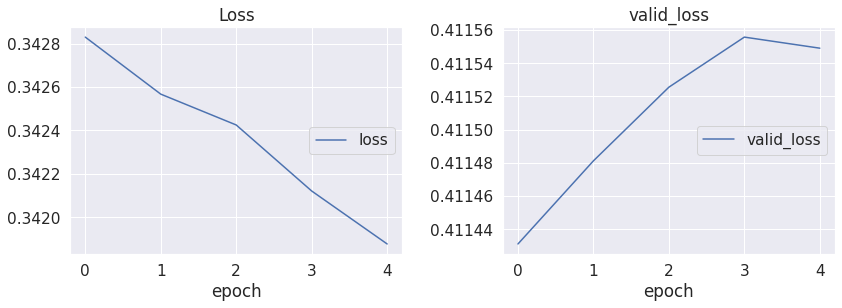

Loss
	loss             	 (min:    0.342, max:    1.399, cur:    0.342)
valid_loss
	valid_loss       	 (min:    0.405, max:    1.379, cur:    0.412)
 Epoch 006



	Epoch #:  5 [loss: 0.3416, val_loss: 0.4115
... Done!
1 loop, best of 3: 3min 23s per loop


In [64]:
%%timeit

trainer.train(train_dataset_, dev_dataset_, epochs=50)

## Visualize TensorBoard

In [0]:
import os

logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)


# %load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 1164), started 0:00:31 ago. (Use '!kill 1164' to kill it.)

<IPython.core.display.Javascript object>

## Save the model

In [0]:
save_model_path = os.path.join(RESOURCES_PATH, 'fasttext_bilstm_model.pt')
torch.save(baseline_model.state_dict(), save_model_path)

## Load Model


In [0]:
save_model_path = os.path.join(RESOURCES_PATH, 'bilstm_model.pt')

model = BaselineModel(hyperparams) 
model.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

## Evaluate the model

In [70]:
test_set_loss, test_set_acc = trainer.evaluate(dev_dataset_)
print(f"Test set \nLoss: {test_set_loss:.5f}, Acc: {test_set_acc * 100:.5f}%")

Test set 
Loss: 0.41154, Acc: 1.62563%


In [71]:
dev_data = dev_dataset.encoded_data
y_test = []
y_pred = []
for i in range(len(dev_data)):
    test_x, test_y = dev_data[i]["inputs"], dev_data[i]["outputs"]
    logits, _ = trainer.predict(test_x.unsqueeze(0))
    test_y = WikiDataset.decode_data(test_y, train_dataset.idx2label)
    pred_y = WikiDataset.decode_output(logits, train_dataset.idx2label)[0]
    y_pred.append(pred_y)
    y_test.append(test_y)

with open('predictions.txt', encoding='utf-8', mode='w+') as outputs_file:
    for prediciton in tqdm(y_pred, desc='Writing predictions'):
        outputs_file.write(f"{''.join(prediciton)}\n")

In [0]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_score


def compute_scores(model:nn.Module, l_dataset:DataLoader, l_label_vocab):
    all_predictions = list()
    all_labels = list()
    for indexed_elem in l_dataset:
        indexed_in = indexed_elem["inputs"]
        indexed_labels = indexed_elem["outputs"]
        predictions = model(indexed_in)
        predictions = torch.argmax(predictions, -1).view(-1)
        labels = indexed_labels.view(-1)
        valid_indices = labels != 0
        
        valid_predictions = predictions[valid_indices]
        valid_labels = labels[valid_indices]
        
        all_predictions.extend(valid_predictions.tolist())
        all_labels.extend(valid_labels.tolist())
    # global precision. Does take class imbalance into account.
    micro_precision_recall_fscore = precision_recall_fscore_support(all_labels, all_predictions, average="micro", zero_division=0)

    # precision per class and arithmetic average of them. Does not take into account class imbalance.
    macro_precision_recall_fscore = precision_recall_fscore_support(all_labels, all_predictions, average="macro", zero_division=0)
    per_class_precision = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    
    return {"macro_precision_recall_fscore":macro_precision_recall_fscore, 
            "micro_precision_recall_fscore":micro_precision_recall_fscore,
            "per_class_precision":per_class_precision,
            "confusion_matrix": confusion_matrix(all_labels, all_predictions, normalize='true')}


In [73]:
scores = compute_scores(baseline_model, dev_dataset_, train_dataset.label2idx)

per_class_precision = scores["per_class_precision"]

precision_, recall_, f1score_, _ = scores['macro_precision_recall_fscore']
print(f"Macro Precision: {precision_}")
print(f"Macro Recall: {recall_}")
print(f"Macro F1_Score: {f1score_}")

print("Per class Precision:")
for idx_class, precision in sorted(enumerate(per_class_precision), key=lambda elem: -elem[1]):
    label = train_dataset.idx2label[idx_class]
    print(f'{label}: {precision}')


precision, recall, f1score, _ = scores['micro_precision_recall_fscore']
print(f"Micro Precision: {precision}")
print(f"Micro Recall: {recall}")
print(f"Micro F1_Score: {f1score}")


confusion_matrix = scores['confusion_matrix']
print(confusion_matrix)

Macro Precision: 0.8548850181628828
Macro Recall: 0.7613001446925224
Macro F1_Score: 0.7791831560070556
Per class Precision:
I: 1.0
B: 0.8338436877526726
<PAD>: 0.730811366735976
Micro Precision: 0.8510909340242943
Micro Recall: 0.8510909340242943
Micro F1_Score: 0.8510909340242943
[[0.31681738 0.68318262 0.        ]
 [0.03291695 0.96708305 0.        ]
 [0.         0.         1.        ]]


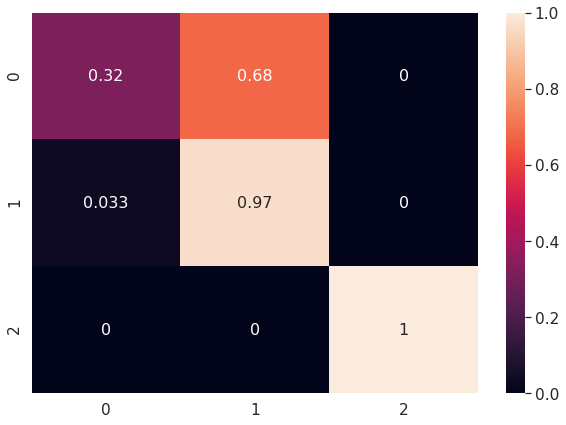

In [74]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


num_classes = hyperparams.num_classes - 1
df_cm = pd.DataFrame(confusion_matrix, range(num_classes), range(num_classes))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()